Model Evaluation:
Accuracy: 0.8673

Confusion Matrix:
[[707 109]
 [ 14  97]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       816
           1       0.47      0.87      0.61       111

    accuracy                           0.87       927
   macro avg       0.73      0.87      0.77       927
weighted avg       0.92      0.87      0.88       927


Feature Importances:
           Feature    Importance
10        duration  4.511502e-01
19     nr.employed  3.348381e-01
17   cons.conf.idx  1.156791e-01
18       euribor3m  3.249816e-02
0              age  2.501357e-02
12           pdays  2.114628e-02
1              job  7.944199e-03
11        campaign  7.888013e-03
7          contact  2.796799e-03
8            month  8.917457e-04
9      day_of_week  1.538413e-04
3        education  1.955127e-16
2          marital  0.000000e+00
5          housing  0.000000e+00
6             loan  0.000000e+00
4          default  0.

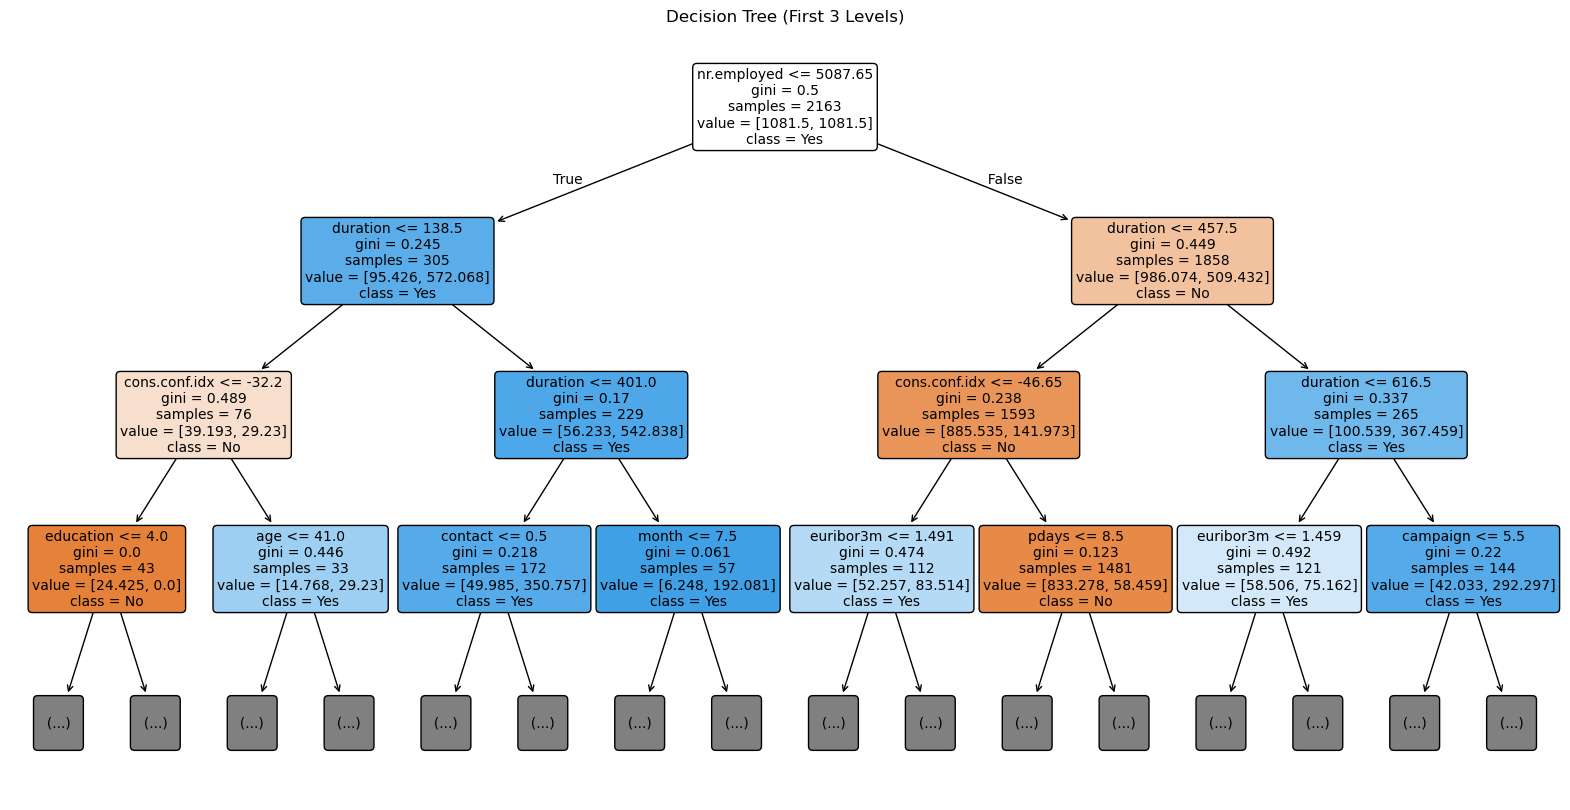


Decision Tree Rules (first 3 levels):
|--- nr.employed <= 5087.65
|   |--- duration <= 138.50
|   |   |--- cons.conf.idx <= -32.20
|   |   |   |--- education <= 4.00
|   |   |   |   |--- class: 0
|   |   |   |--- education >  4.00
|   |   |   |   |--- class: 0
|   |   |--- cons.conf.idx >  -32.20
|   |   |   |--- age <= 41.00
|   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- age >  41.00
|   |   |   |   |--- class: 0
|   |--- duration >  138.50
|   |   |--- duration <= 401.00
|   |   |   |--- contact <= 0.50
|   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- contact >  0.50
|   |   |   |   |--- class: 1
|   |   |--- duration >  401.00
|   |   |   |--- month <= 7.50
|   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- month >  7.50
|   |   |   |   |--- class: 1
|--- nr.employed >  5087.65
|   |--- duration <= 457.50
|   |   |--- cons.conf.idx <= -46.65
|   |   |   |--- euribor3m <= 1.49
|   |   |   |   |--- truncated branch of depth 2
|   |  

In [1]:
# Import required libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('bank-additional.csv', sep=';')

# Data preprocessing
# Handle missing values if any (this dataset uses 'unknown' as missing for some categorical features)
data.replace('unknown', pd.NA, inplace=True)
data.dropna(inplace=True)  # or use other imputation methods

# Encode categorical variables
label_encoders = {}
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 
                    'contact', 'month', 'day_of_week', 'poutcome', 'y']

for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    label_encoders[col] = le

# Separate features and target
X = data.drop('y', axis=1)
y = data['y']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3,       # 30% for testing
    random_state=42,     # for reproducibility
    stratify=y           # maintain class distribution
)

# Initialize and train the decision tree classifier with parameters
dt_classifier = DecisionTreeClassifier(
    criterion='gini',     # or 'entropy' for information gain
    splitter='best',      # or 'random' for random splits
    max_depth=5,          # maximum depth of tree
    min_samples_split=20, # minimum samples required to split a node
    min_samples_leaf=10,  # minimum samples required at a leaf node
    max_features=None,    # number of features to consider for best split
    random_state=42,      # for reproducibility
    class_weight='balanced' # adjusts weights inversely proportional to class frequencies
)

# Train the model
dt_classifier.fit(X_train, y_train)

# Make predictions
y_pred = dt_classifier.predict(X_test)
y_pred_proba = dt_classifier.predict_proba(X_test)[:, 1]  # probabilities for the positive class

# Evaluate the model
print("Model Evaluation:")
print("="*50)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt_classifier.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)

# Visualize the decision tree (first 3 levels for readability)
plt.figure(figsize=(20,10))
plot_tree(dt_classifier, 
          feature_names=X.columns, 
          class_names=['No', 'Yes'], 
          filled=True, 
          rounded=True,
          max_depth=3,  # show only first 3 levels
          fontsize=10)
plt.title("Decision Tree (First 3 Levels)")
plt.show()

# Print text representation of the tree (first few levels)
tree_rules = export_text(
    dt_classifier, 
    feature_names=list(X.columns),
    max_depth=3  # show only first 3 levels
)
print("\nDecision Tree Rules (first 3 levels):")
print(tree_rules)

# Additional metrics (optional)
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score

print("\nAdditional Metrics:")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"Average Precision: {average_precision_score(y_test, y_pred_proba):.4f}")